In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,precision_score,recall_score,f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

In [30]:
df = pd.read_csv("bank_additional_full_cleaned.csv")


In [31]:
df.shape

(41188, 21)

In [32]:
nul=df.isnull().sum()
nul

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [33]:
dup=df.duplicated().sum()
dup

np.int64(12)

In [34]:
df = df.drop_duplicates()

Skewness (numeric):
campaign          4.762044
previous          3.831396
duration          3.262808
age               0.784560
cons.conf.idx     0.302876
cons.price.idx   -0.230853
euribor3m        -0.709194
emp.var.rate     -0.724061
nr.employed      -1.044317
pdays            -4.921386
dtype: float64


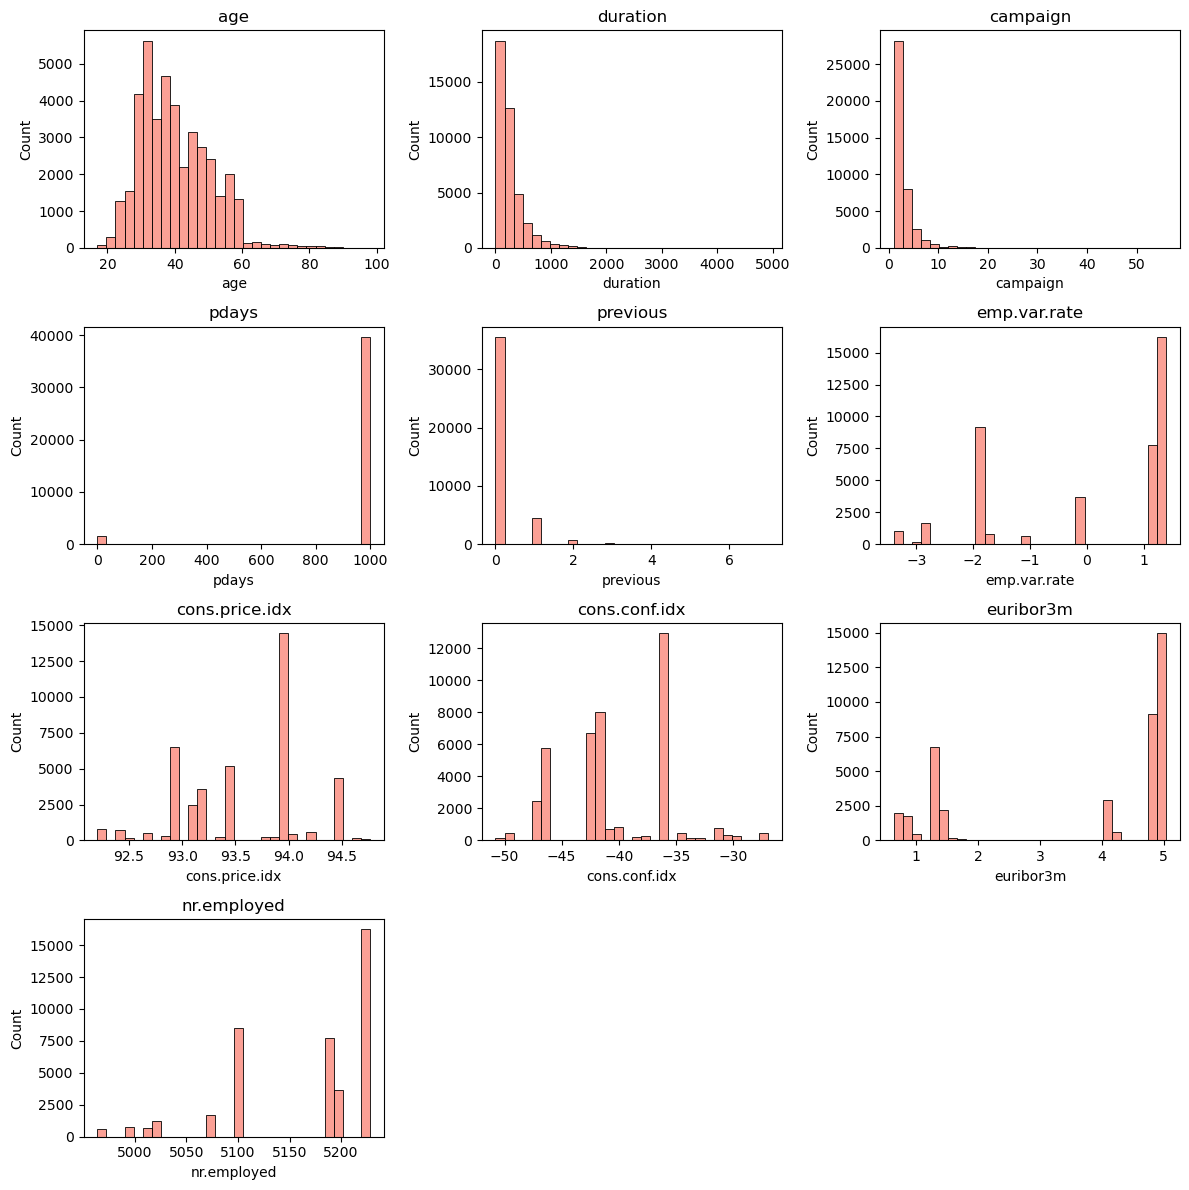

In [35]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Compute skewness
skew_vals = df[numeric_cols].skew(numeric_only=True)
print("Skewness (numeric):")
print(skew_vals.sort_values(ascending=False))


n = len(numeric_cols)
cols = 3
rows = int(np.ceil(n / cols)) if n > 0 else 0
if n > 0:
    plt.figure(figsize=(12, 3 * rows))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(rows, cols, i)
        sns.histplot(df[col].dropna(), kde=False, bins=30, color='salmon')
        plt.title(col)
    plt.tight_layout()
    plt.show()


In [36]:
features = [
    'age','job','marital','education','default','housing','loan',
    'contact','month','day_of_week','campaign','pdays','previous','poutcome',
    'emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed'
]
X = df[features]
y = df['y'].map({'yes': 1, 'no': 0})  

cat_cols = ['job','marital','education','default','housing','loan',
            'contact','month','day_of_week','poutcome']
num_cols = [col for col in X.columns if col not in cat_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ]
)

X_processed = preprocessor.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print(class_weight_dict)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    verbose=1,
    class_weight=class_weight_dict
)
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy (from model.evaluate): {acc:.4f}")

{np.int64(0): np.float64(0.5634814738786821), np.int64(1): np.float64(4.438156831042845)}
Epoch 1/20
412/412 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7743 - loss: 0.5678 - val_accuracy: 0.8169 - val_loss: 0.5216
Epoch 2/20
412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8190 - loss: 0.5433 - val_accuracy: 0.8320 - val_loss: 0.5444
Epoch 3/20
412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8267 - loss: 0.5381 - val_accuracy: 0.8532 - val_loss: 0.4809
Epoch 4/20
412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8304 - loss: 0.5364 - val_accuracy: 0.8291 - val_loss: 0.5476
Epoch 5/20
412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8292 - loss: 0.5333 - val_accuracy: 0.8335 - val_loss: 0.5365
Epoch 6/20
412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8331 - loss: 0.5308 - val_accuracy: 0.8434 - val_loss: 0.5162
Epoch 7/20
412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8340 - loss: 0.5277 - val_accuracy: 0.8274 - val_loss: 0.5545
Epoch 8/20
412

In [37]:
y_pred_prob = model.predict(X_test, verbose=0).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print("\nMetrics on test set:")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred):.4f}")


Metrics on test set:
Accuracy : 0.8379
Precision: 0.3737
Recall   : 0.6487
F1 Score : 0.4742


In [38]:
import joblib

joblib.dump(model, 'Bank_model.joblib')


['Bank_model.joblib']